Create compression version of GPT-2 nad BERT model and save the memory =)

## stsb example

The Semantic Textual Similarity Benchmark (Cer et al., 2017) is a collection of sentence pairs drawn from news headlines, video and image captions, and natural language inference data. Each pair is human-annotated with a similarity score from 0 to 5.

In [ ]:
#!pip install Partial State

In [1]:
import transformers
print (transformers.__version__)

4.30.2


In [2]:
#!pip install datasets evaluate

In [3]:
#!pip3 install --upgrade pip
#!pip3 install --upgrade transformers

In [4]:
from datasets import load_dataset
import pandas as pd

dataset_stsb = load_dataset('glue', 'stsb')
dataset_stsb.num_rows

Found cached dataset glue (/root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'train': 5749, 'validation': 1500, 'test': 1379}

In [5]:
len(pd.DataFrame(dataset_stsb['train']))

5749

In [6]:
task_num_labels = 1

from transformers import AutoConfig, BertConfig, AutoModelForSequenceClassification, AutoTokenizer

path_name = r"bert-base-uncased"

config = AutoConfig.from_pretrained(
    path_name,
    num_labels=task_num_labels,
)

model = AutoModelForSequenceClassification.from_pretrained(
    path_name,
    config=config,
)

tokenizer = AutoTokenizer.from_pretrained(path_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [7]:
model.bert.encoder.layer[0].intermediate.dense.weight.shape

torch.Size([3072, 768])

In [8]:
model.bert.encoder.layer[0].intermediate.dense.weight.shape

torch.Size([3072, 768])

In [9]:
from sparse_grad import replace_bert_layers

def sparse_grad_linear(model, *args):
    print ("create bert with sparse grads")
    model = replace_bert_layers(model)
    print ("created bert with sparse grads")
    return model

In [10]:
model = sparse_grad_linear(model)

create bert with sparse grads
created bert with sparse grads


In [11]:
def convert_to_stsb_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=128, truncation=True, padding="max_length")
    features["labels"] = example_batch["label"]
    return features

In [12]:
tokenized_dataset = dataset_stsb.map(
            convert_to_stsb_features,
            batched=True,
            load_from_cache_file=False,
            )

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [13]:
len(tokenized_dataset['train'])

5749

In [14]:
from torch.utils.data import DataLoader, RandomSampler

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=10)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
import torch 

from transformers import Trainer
import evaluate as ev
import numpy as np

from transformers import TrainingArguments, Trainer, EvalPrediction

class TrainerBert(Trainer):
    
    def make_grad_bank(self):
        self.n_show = 3
        self.losses = []
    
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        loss.backward()
        for layer in range(12):
                
            if (model.bert.encoder.layer[layer].output.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].output.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].output.dense.weight.grad
                model.bert.encoder.layer[layer].output.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))

            if (model.bert.encoder.layer[layer].intermediate.dense.len_grads) < 30:
                model.bert.encoder.layer[layer].intermediate.dense.len_grads += 1
                cur_grad = model.bert.encoder.layer[layer].intermediate.dense.weight.grad
                model.bert.encoder.layer[layer].intermediate.dense.grads.append(torch.empty_like(cur_grad).copy_(cur_grad))
                

            else:
                
                if (self.n_show > 0):
                    self.n_show -= 1
                    im= plt.imshow(model.bert.encoder.layer[layer].output.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].output.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show))
                    plt.colorbar(im) #not in spy
                    plt.show()
                    #plt.colorbar(im2)
                    #plt.show()
                    #plt.colorbar(im3)
                    #plt.show()
                    #plt.colorbar(im4)
                    #plt.show()
                    #plt.colorbar(im5)
                    plt.show()

                    im= plt.imshow(model.bert.encoder.layer[layer].intermediate.dense.weight.grad[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')#not in spy
                    print ("number of nonzero ", torch.count_nonzero(model.bert.encoder.layer[layer].intermediate.dense.weight.grad.cpu().detach()))
                    plt.title('grad '+'20x20 ' + str(self.n_show)) 
                    plt.colorbar(im) #not in spy
                    plt.show()
                
                    
        
        

        self.losses.append(loss.cpu().detach().numpy())
        return loss.detach()

2023-07-18 17:48:17.253920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [17]:
metric = ev.load("glue", 'stsb')

In [18]:
def compute_metrics(p: EvalPrediction):
        preds_ = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds_ = np.squeeze(preds_)

        result = metric.compute(predictions=preds_, 
                                references=p.label_ids)
        if len(result) > 1:
            result["combined_score"] = np.mean(list(result.values())).item()
        return result

In [19]:
training_args = TrainingArguments(
    learning_rate=5e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    save_steps=1000,
    eval_steps=500,
    overwrite_output_dir=True,
    output_dir="./bert_stsb_128",
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=True,
    seed=297104,
    report_to='none',
    )

In [20]:
trainer = TrainerBert(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
)
trainer.make_grad_bank()
trainer.args._n_gpu=1

In [31]:
len(trainer.eval_dataset)

1500

In [32]:
aa = model.bert.encoder.layer[0].output.dense
aaw = aa.weight.grad
U = aa.U
VT = aa.VT

AttributeError: 'Linear' object has no attribute 'U'

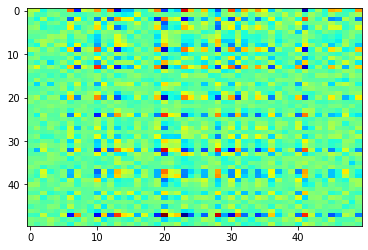

In [23]:
im2 = plt.imshow(aaw[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')

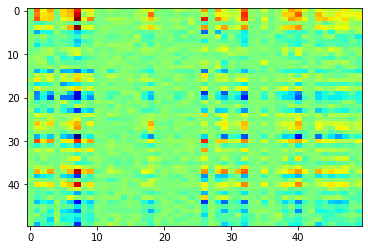

In [24]:
im2 = plt.imshow((aa.U.T@aaw@aa.VT)[:50, :50].cpu().detach().numpy(), cmap='jet', aspect='auto')

In [ ]:
plt.colorbar(im2)
plt.show()

len small dataset 5749
lets collect gradients


/opt/.pyenv/versions/3.8.10/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
created matrix
self.len_grads 30
number of nonzero  tensor(2359296)


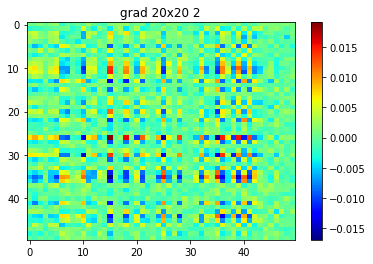

number of nonzero  tensor(2359296)


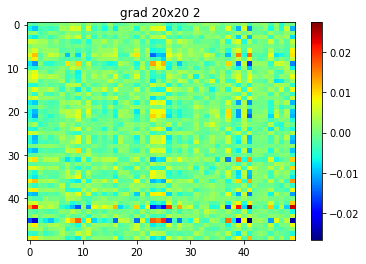

number of nonzero  tensor(2359296)


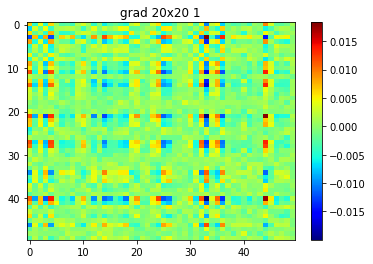

number of nonzero  tensor(2359296)


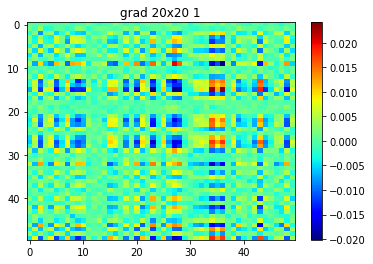

number of nonzero  tensor(2359296)


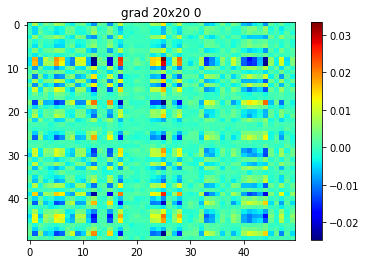

number of nonzero  tensor(2359296)


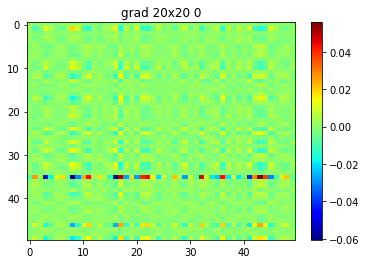

finishing collecting gradients


In [21]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

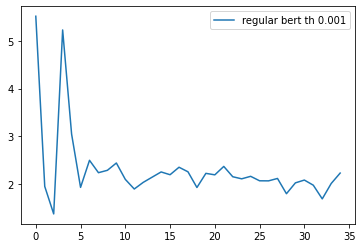

In [22]:
#plt.plot(np.mean(np.array(a)[:350].reshape(-1, 10), axis=1), label = "bert in new basis")
#plt.plot(np.mean(np.array(b)[:350].reshape(-1, 10), axis=1), label = "regular bert")
plt.plot(np.mean(np.array(trainer.losses)[:350].reshape(-1, 10), axis=1), label = "regular bert th 0.001")
plt.legend()

In [ ]:
print ("len small dataset", len(trainer.train_dataset))
print ("lets collect gradients")
train_result = trainer.train()
print ("finishing collecting gradients")
#model = create_space_matrices(model)

In [ ]:
trainer.evaluate()

In [ ]:
#import sys,os,os.path

#os.environ["TOKENIZERS_PARALLELISM"]="false"
#os.environ["WANDB_DISABLED"] = "true"

In [ ]:
#a = trainer.losses
#b = trainer.losses

In [ ]:
import pickle
with open('./stsb_pickles/bert_sparse_001.pkl', 'wb') as f:
    pickle.dump(np.array(trainer.losses), f)

In [ ]:
import pickle
a = pickle.load( open( "./stsb_pickles/bert_sparse.pkl", "rb" ) ) 
b = pickle.load( open( "./stsb_pickles/regular_bert.pkl", "rb" ) ) 

In [ ]:
import pickle
freeze = pickle.load( open( "./freeze_all_except_last.pkl", "rb" ) ) 

In [ ]:
trainer.train()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers freeze rest')
plt.plot(freeze, label='freeze dense layers freeze rest')
#plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='unfreeze dense layers freeze rest')
plt.plot(freeze, label='freeze dense layers freeze rest')
#plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='sparse dense layers')
plt.plot(full, label='unfreeze dense layers')
plt.plot(freeze, label='freeze dense layers')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.savefig("freeze0.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainer.losses, label='all zeros')
plt.plot(full, label='full grads')
plt.title("Loss curves")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
a = np.stack(trainer.grad_bank_out[4][:28], axis = 0)
print (a.shape)
a = np.moveaxis(a, 0, 2)
print (a.shape)

In [ ]:
len(dict_int[0][4])

In [ ]:
import torch
dict_int = get_tucker_tensors(trainer.grad_bank_int)
dict_out = get_tucker_tensors(trainer.grad_bank_out)
print (dict_int[0].shape)
print (dict_int[1].shape)
for i in range(1):
    u1_int, u2_int = Tucker_Decomposition(dict_int[i])
    u1_out, u2_out = Tucker_Decomposition(dict_out[i])

In [ ]:
for i in range(1):
    print(i)

In [ ]:
print (u1_int.shape, u2_int.shape)

In [ ]:
def func_collecting_tensors(step, tensor1, tensor2=None):
    if step == 0:
        return tensor1.unsqueeze(0)
    else:
        return torch.concatenate((tensor1, tensor2),0)
    
def Tucker_Decomposition(tensor):
    n1, n2, n3 = tensor.shape
    u1, s1, v1 = np.linalg.svd(np.reshape(tensor, (n1, -1)), full_matrices=False)
    u2, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[1,2,0]), (n2, -1)), full_matrices=False)
    u3, s1, v1 = np.linalg.svd(np.reshape(np.transpose(tensor,[2,0,1]), (n3, -1)), full_matrices=False)
    return u1, u2

def get_tucker_tensors(dict_layers):
    '''
    делает словарь где ключом будет слой, а значением будет тензор
    '''
    dict_tensor = dict(zip(range(12), [None]*12))
    for key in dict_layers.keys():
        dict_tensor[key] = np.moveaxis(np.stack(dict_layers[key][:28], axis = 0), 0, 2)
    return dict_tensor
    

In [ ]:
u1_int.T.shape

In [ ]:
matrix.shape

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_int[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_int.T @ matrix @ u2_int
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
for ind, matrix in enumerate(trainer.grad_bank_out[0][26:]):
    print ("layer", 0, "batch", ind+26)
    matrix_in_basis = u1_out.T @ matrix @ u2_out
    im= plt.imshow(matrix_in_basis, cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS ') 
    plt.colorbar(im) #not in spy
    plt.show()

    im= plt.imshow(matrix_in_basis[:50, :50], cmap='jet', aspect='auto')#not in spy
    plt.title('GRAD WEIGHTS '+'20x20 ') 
    plt.colorbar(im) #not in spy
    plt.show()
    print('\n\n\n\n')

In [ ]:
import pickle

with open('regular_grad_int.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('regular_grad_out.pcl', 'wb') as fp:
    pickle.dump(trainer.grad_bank_out, fp, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
import pickle

with open('sparse_s.pcl', 'wb') as fp:
    pickle.dump(trainer.sparse_grad_bank_int, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('regular_grad_int.pcl', 'rb') as fp:
    data = pickle.load(fp)

In [ ]:
len(data[2])

In [ ]:
for layer in range(len(trainer.sparse_grad_bank_int)):
  for batch in range(len(trainer.sparse_grad_bank_int[layer])):
      S_hat_zero= trainer.sparse_grad_bank_int[layer][batch]
      print ("layer", layer, "batch", batch)
      im= plt.imshow(S_hat_zero, cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS ') 
      plt.colorbar(im) #not in spy
      plt.show()

      im= plt.imshow(S_hat_zero[:20, :20], cmap='jet', aspect='auto')#not in spy
      plt.title('GRAD WEIGHTS '+'20x20 ') 
      plt.colorbar(im) #not in spy
      plt.show()
      print('\n\n\n\n')

get proper gradients (3rd output 3 layer)

In [ ]:
trainer.grad_bank_out[3]

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model()  # Saves the tokenizer too for easy upload
#trainer.log_metrics("train", metrics)
metrics = trainer.evaluate()
trainer.save_metrics("eval", metrics)
trainer.save_state()
sst_new_path = r"./bert_stsb_128"

In [ ]:
#our model's params
orig_param = trainer.model.num_parameters() / 1000 / 1000
orig_param

In [ ]:
device='cuda'
def svd_compress_bert_ffn(model_to, svd_rank = 51):
    for i in range(model_to.config.num_hidden_layers):
        # fc part
        fc_w = model_to.bert.encoder.layer[i].intermediate.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].intermediate.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].intermediate.dense = factorized_layer
        
        fc_w = model_to.bert.encoder.layer[i].output.dense.weight.data.cpu().data.numpy()
        fc_b = model_to.bert.encoder.layer[i].output.dense.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(fc_w, fc_b, rank = svd_rank)
        model_to.bert.encoder.layer[i].output.dense = factorized_layer

In [ ]:
from typing import List, Callable
import torch
import torch.nn as nn
import tntorch as tn
from math import sqrt

from ttm_opt import einsum_forward

class TTLinearOpt(nn.Module):
    def __init__(self, in_features: int, out_features: int, ranks: List[int], input_dims: List[int],
                 output_dims: List[int], bias: bool = True, device=None, dtype=None,
                 forward_fn: Callable = einsum_forward):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.ranks = list(ranks)
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.forward_fn = forward_fn

        # Initialize weights from uniform[-1 / sqrt(in_features), 1 / sqrt(in_features)]
        factory_kwargs = {"device": device, "dtype": dtype}
        init = torch.rand(in_features, out_features, **factory_kwargs)
        init = (2 * init - 1) / sqrt(in_features)
        
        self.weight = tn.TTMatrix(init, list(ranks), input_dims, output_dims)

        # torch doesn't recognize attributes of self.weight as parameters,
        # so we have to use ParameterList
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

        if bias:
            init = torch.rand(out_features, **factory_kwargs)
            init = (2 * init - 1) / sqrt(out_features)
            self.bias = nn.Parameter(init)
        else:
            self.register_parameter('bias', None)


    def forward(self, x: torch.Tensor):
        res = self.forward_fn(self.cores, x)

        new_shape = x.shape[:-1] + (self.out_features,)
        res = res.reshape(*new_shape)

        if self.bias is not None:
            res += self.bias

        return res

    def set_weight(self, new_weights: torch.Tensor):
        # in regular linear layer weights are transposed, so we transpose back
        new_weights = new_weights.clone().detach().T

        shape = torch.Size((self.in_features, self.out_features))
        assert new_weights.shape == shape, f"Expected shape {shape}, got {new_weights.shape}"

        self.weight = tn.TTMatrix(new_weights, self.ranks, self.input_dims, self.output_dims)
        self.cores = nn.ParameterList([nn.Parameter(core) for core in self.weight.cores])
        self.weight.cores = self.cores

    def set_from_linear(self, linear: nn.Linear):
        self.set_weight(linear.weight.data)
        self.bias = nn.Parameter(linear.bias.data.clone()) if linear.bias is not None else None

In [ ]:
def ttm_compress_bert_ffn(model, rank):
    if hasattr(model, "bert") and hasattr(model.bert, "encoder"):
        encoder = model.bert.encoder
    elif hasattr(model, "encoder"):
        encoder = model.encoder
    else:
        raise ValueError("Expected model to have attribute 'encoder' or 'bert.encoder'.")

    for i, layer in enumerate(encoder.layer):
        token_dim, hidden_dim = layer.intermediate.dense.weight.T.shape

        tt_weight = TTLinearOpt(768, 3072, [rank]*2,  [8,12,8], [12,16,16], bias=True)
        tt_weight.set_from_linear(layer.intermediate.dense)

        layer.intermediate.dense = tt_weight

        # second linear layerhas reversed dimensions,
        # so we swap input_dims and output_dims
        tt_weight = TTLinearOpt(3072, 768, [rank]*2, [12,16,16], [8,12,8], bias=True)
        tt_weight.set_from_linear(layer.output.dense)

        layer.output.dense = tt_weight

    return model

In [ ]:
from tqdm import tqdm

In [ ]:
dd = []
device='cuda'
for ii in tqdm([6,10,20]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    svd_compress_bert_ffn(trainer.model, ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd.append([new_param, ar['eval_pearson']])

In [ ]:
dd_ttm = []
for ii in tqdm([6,10,20]): #,42,48,54,60,66,72,78,84]):
    trainer.model = AutoModelForSequenceClassification.from_pretrained(
                                                    sst_new_path,
                                                    config=config,
                                                    )
    ttm_compress_bert_ffn(trainer.model,ii)
    trainer.model.to('cuda')
    new_param = trainer.model.num_parameters() / 1000 / 1000
    new_param /= orig_param
    ar = trainer.evaluate(tokenized_dataset["validation"])
    dd_ttm.append([new_param, ar['eval_pearson']])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ax = sns.lineplot(x=0, y=1, data = pd.DataFrame(dd), label='Pearson SVD')
plt.axhline(y=0.89, ls='--', c='red') #non-compressed accuracy
ax.set(xlabel ='% of original params')
sns.lineplot(x=0, y=1, data = pd.DataFrame(dd_ttm), label='Pearson TTM')